<a href="https://colab.research.google.com/github/11kraj/Lung_segmentation/blob/main/Lung_segmentation_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "karthikrajshetty"
os.environ['KAGGLE_KEY'] = "ded47b481af6e22560a06bd18993c8b1"

In [ ]:
!kaggle datasets download nikhilpandey360/chest-xray-masks-and-labels

100% 9.56G/9.58G [01:29<00:00, 109MB/s] 
100% 9.58G/9.58G [01:29<00:00, 115MB/s]


In [ ]:
!unzip /content/chest-xray-masks-and-labels.zip

Archive:  /content/chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0014_0.png  
  inflating: Lung Segmentation/CXR_png/CHNC

In [ ]:
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from skimage import measure

In [ ]:
DIR="/content/data"
lung_image_paths=glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths=glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

In [ ]:
related_paths=defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)



paths_df = pd.DataFrame.from_dict(related_paths)

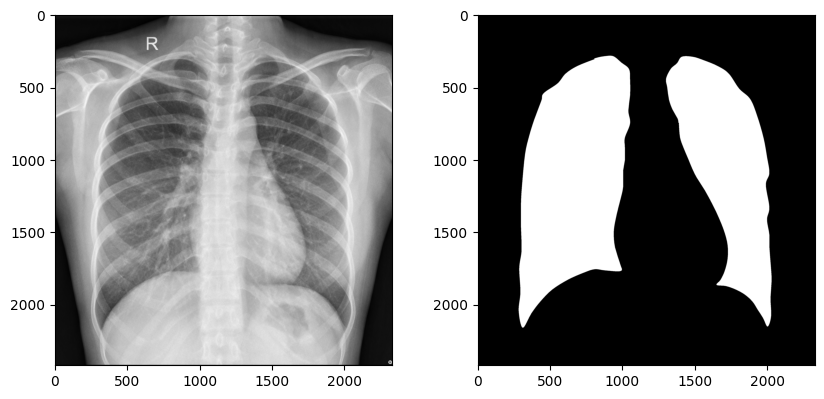

In [ ]:
xray_num = 9
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [ ]:
import cv2
from tqdm import tqdm

In [ ]:
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array
img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 704/704 [00:52<00:00, 13.45it/s]


In [ ]:
# https://www.kaggle.com/code/scratchpad/notebook6bd3de822c/edit

In [ ]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size)

In [ ]:
### U-net

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    # up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    # conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
from tensorflow.keras.optimizers import Adam
EPOCHS = 10
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy", \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1,
                             save_best_only=True, #mode='min',
                             save_weights_only = True)


early = EarlyStopping(monitor="loss",
                      #mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [ ]:
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(x = img_train,
                    y = mask_train,
                    validation_data = (img_test, mask_test),
                    epochs = 10,
                    batch_size = 16,
                   callbacks = callbacks_list)
model.save('my_model.h5')

Epoch 1/10
36/36 [==============================] - 65s 887ms/step - loss: 0.5843 - dice_coef: 0.2921 - binary_accuracy: 0.7300 - val_loss: 0.4523 - val_dice_coef: 0.3448 - val_binary_accuracy: 0.7531
Epoch 2/10
36/36 [==============================] - 21s 587ms/step - loss: 0.3896 - dice_coef: 0.4451 - binary_accuracy: 0.7849 - val_loss: 0.3183 - val_dice_coef: 0.5057 - val_binary_accuracy: 0.8367
Epoch 3/10
36/36 [==============================] - 22s 625ms/step - loss: 0.2981 - dice_coef: 0.6337 - binary_accuracy: 0.8802 - val_loss: 0.1941 - val_dice_coef: 0.7887 - val_binary_accuracy: 0.9275
Epoch 4/10
36/36 [==============================] - 21s 597ms/step - loss: 0.1748 - dice_coef: 0.8025 - binary_accuracy: 0.9351 - val_loss: 0.1488 - val_dice_coef: 0.8436 - val_binary_accuracy: 0.9454
Epoch 5/10
36/36 [==============================] - 21s 591ms/step - loss: 0.1270 - dice_coef: 0.8577 - binary_accuracy: 0.9524 - val_loss: 0.1412 - val_dice_coef: 0.8441 - val_binary_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('my_model.h5')


1/1 [==============================] - 1s 1s/step


0.9629459298819445

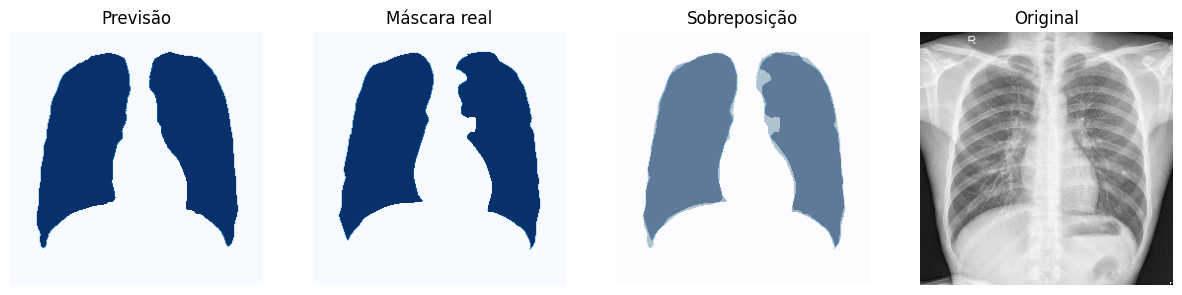

In [ ]:
def test_on_image(model, img_array, img_num, img_side_size = 256):

    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))

    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Previsão")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Máscara real");
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Sobreposição")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")

    return pred
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3 #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
prediction = test_on_image(model, img_array = img_test, img_num = IMG_NUM, img_side_size = 256)
dice_coef_test(y_true = mask_test[IMG_NUM], y_pred = prediction)

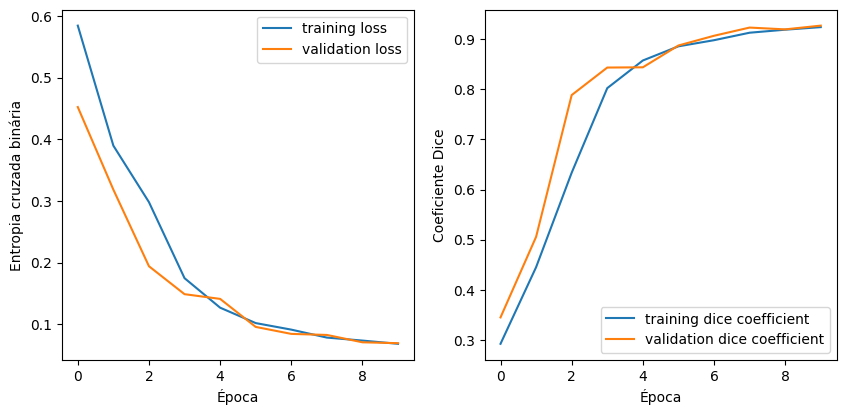

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Época")
    plt.ylabel("Entropia cruzada binária")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Época")
    plt.ylabel("Coeficiente Dice")

get_metrics(history = history)